In [3]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score


In [4]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Ensure nltk data is downloaded
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# List of stopwords
stop_words = set(stopwords.words('english'))




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thania\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thania\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:

base_directory = 'CrisisLexT26-v1.0\CrisisLexT26'  # Update with the path of your directory
stop_words = set('english')  # Update with your list/set of stop words if you have any

all_tweets_df = pd.DataFrame()

# Function to preprocess tweets
def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user mentions
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    # Remove special characters
    tweet = re.sub(r'\W', ' ', tweet)
    # Remove digits
    tweet = re.sub(r'\d', ' ', tweet)
    # Lemmatization and stop word removal
    words = tweet.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]
    tweet = ' '.join(words)
    
    return tweet
 
# Load tweets from the folder structure and preprocess 
for folder_name in os.listdir(base_directory): 
    folder_path = os.path.join(base_directory, folder_name) 
    if os.path.isdir(folder_path): 
        tweets_csv_path = os.path.join(folder_path, f"{folder_name}-tweets_labeled.csv") 
         
        if os.path.exists(tweets_csv_path):  
            df = pd.read_csv(tweets_csv_path)  
            df['Processed_Tweet'] = df[' Tweet Text'].apply(preprocess_tweet)    
            df['Topic'] = folder_name  
            all_tweets_df = pd.concat([all_tweets_df, df], ignore_index=True)

# Filter relevant tweets
relevant_info = ['Related - but not informative', 'Related and informative']
all_tweets_df = all_tweets_df[all_tweets_df[' Informativeness'].isin(relevant_info)]

# Perform clustering with KMeans
vectorizer = TfidfVectorizer(min_df=5, max_df=0.9, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(all_tweets_df['Processed_Tweet'].values)
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
all_tweets_df['predicted_label'] = kmeans.labels_

# Creating a mapping between true labels and predicted clusters
label_map = {}
for cluster in range(n_clusters):
    sub_df = all_tweets_df[all_tweets_df['predicted_label'] == cluster]
    if not sub_df.empty:
        label_map[cluster] = sub_df['Topic'].value_counts().idxmax()

all_tweets_df['predicted_topic'] = all_tweets_df['predicted_label'].map(label_map)



accuracy = accuracy_score(all_tweets_df['Topic'], all_tweets_df['predicted_topic'])
print(f"Accuracy: {accuracy*100:.2f}%")


c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy: 75.17%


In [6]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score


# Compute evaluation metrics
ari = adjusted_rand_score(all_tweets_df['Topic'], all_tweets_df['predicted_topic'])
nmi = normalized_mutual_info_score(all_tweets_df['Topic'], all_tweets_df['predicted_topic'])
silhouette = silhouette_score(X, all_tweets_df['predicted_label'])

print(f'Adjusted Rand Index: {ari}')

print(f'Normalized Mutual Information: {nmi}')

print(f'Silhouette Score: {silhouette}')



Adjusted Rand Index: 0.4247932397263245
Normalized Mutual Information: 0.7621528377140486
Silhouette Score: 0.04114786386243881


c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


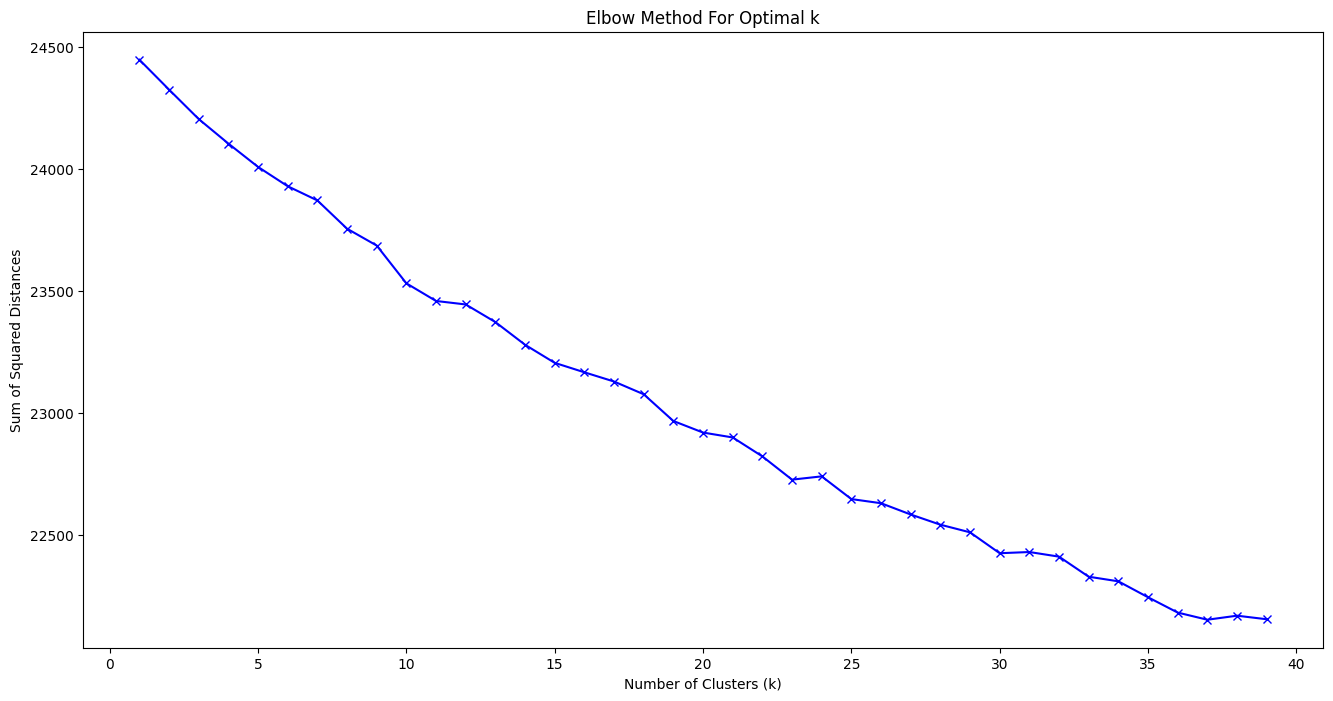

In [8]:
# Elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# This list will hold the sum of squared distances for each number of clusters
sum_of_squared_distances = []

# I'm using a range from 1 to 40 for demonstration purposes; you can adjust this range
K = range(1, 40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

# Plotting the Elbow graph
plt.figure(figsize=(16,8))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()
